In [1]:
import pandas as pd
import numpy as np
import calendar

# Set the figure size - handy for larger output
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = [10, 6]
# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'
import random
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [2]:
df = pd.read_csv('case_study_marketing_20210201.csv',parse_dates=[0], infer_datetime_format=True)

In [3]:
df_use = df.copy()

In [4]:
df_use.dropna(axis=0, inplace=True)

## Remove below cell before uploading

In [12]:
df_use.head(n=3)

,ymd,market_code,account_id,pub_campaign_id,pub_adgroup_id,pub_keyword_id,keyword_name,pub_device,match_type,theme_name_english,...,clickout,bookings,clickout_rev,booking_amount,users_engagement,ctr_in_perc,conversion_rate,profit_margin,month,quarter
0,2020-09-05,DE,321,11312819993,114584083847,4729772737,neos marmaras hotels,phone,0,Hotel,...,0,0.0,0,0.0,490,0.0,0.0,0.0,Sep,Q3
1,2020-09-05,DE,515,180791594,3133140280,76004101942085,altstadt florenz,desktop,0,HotelsHistoricCity,...,0,0.0,0,0.0,455,0.0,0.0,0.0,Sep,Q3
2,2020-09-05,UK,505,180388254,1211662269993764,75729226461556,+apartment +wigan,desktop,2,Apartment,...,0,0.0,0,0.0,207,0.0,0.0,0.0,Sep,Q3


In [6]:
# Calculating metrics
# click through rates (ctr) = total num of clicks / total num of impressions
df_use['ctr_in_perc'] = np.where(df_use.impressions!=0, ((df_use.clickins / df_use.impressions)*100), 0)
# conversion rate = total num of actions completed / total num of visitors in landing page
df_use['conversion_rate'] = np.where(df_use.clickins!=0, ((df_use.clickout / df_use.clickins)*100), 0)
# profit_margin = (rev - total cost)/ rev
df_use['profit_margin'] = np.where(df_use.clickout_rev!=0, ((df_use.clickout_rev - df_use.cost) / df_use.clickout_rev), 0)

In [8]:
# df_use.loc[df_use.impressions==0]
df_use.to_csv('sample.csv')

## EDA

In [9]:
df_use['month'] = df_use.ymd.dt.month
df_use['month'] = df_use['month'].apply(lambda x: calendar.month_abbr[x])

## Which quarter should be the target for maximum bookings?

In [10]:
df_use['quarter'] = df_use.ymd.dt.quarter
df_use['quarter'] = df_use['quarter'].astype(str)
df_use['quarter'] = 'Q' + df_use['quarter']
# df_use['quarter'] = pd.PeriodIndex(df_use.ymd, freq='Q')

In [10]:
total_bookings = df_use.groupby(['market_code', 'quarter'])['bookings'].sum().to_frame().reset_index()
# quarterly_conv_rate = df_use.groupby(['market_code', 'quarter'])['conversion_rate'].mean().to_frame().reset_index()

Text(0.5, 1.0, 'Quarterly Booking Overview')

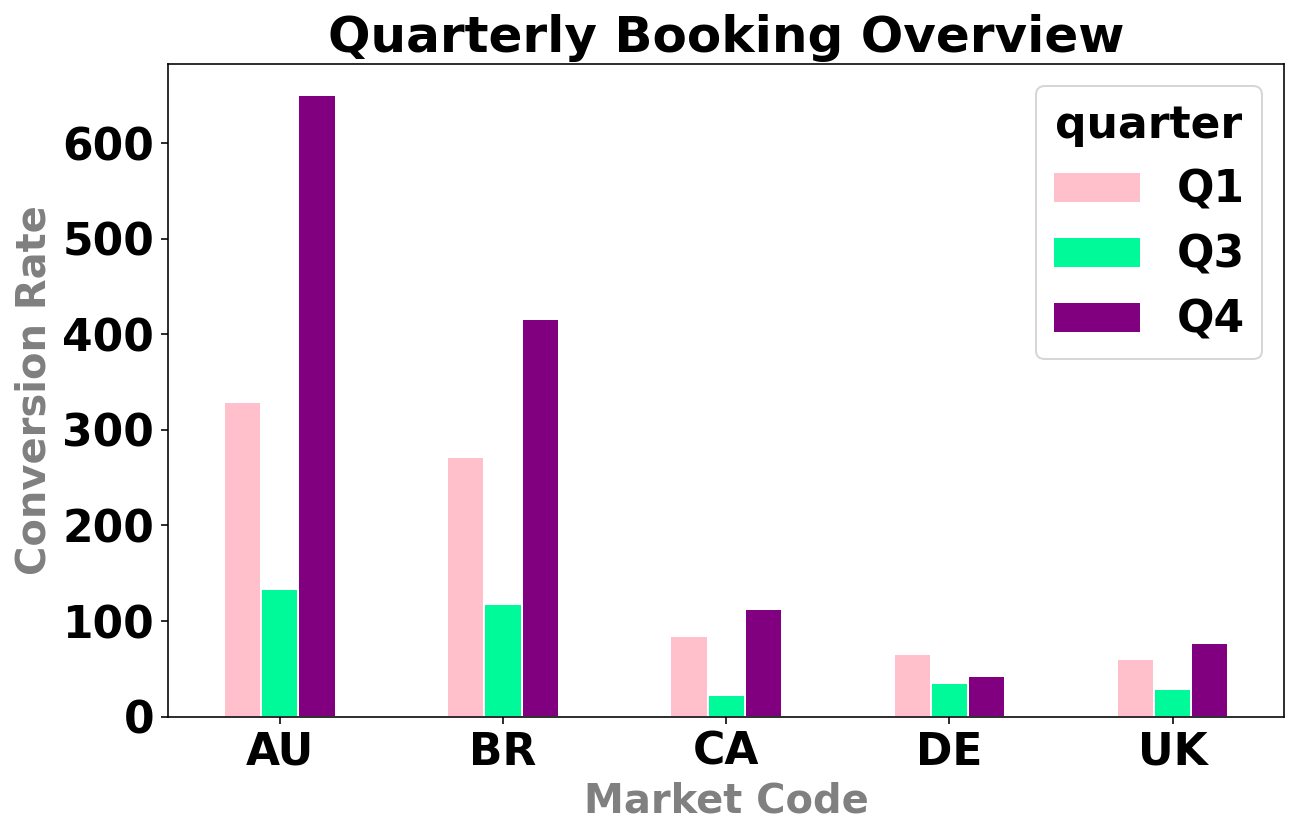

In [146]:
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 3)
total_bookings.pivot('market_code', 'quarter', 'bookings').plot(kind='bar', edgecolor='white', color=colors)
plt.xticks(rotation=0)
plt.xlabel('Market Code', {'fontsize': 20,'fontweight': 'bold','color': 'grey'})
plt.ylabel('Bookings', {'fontsize': 20,'fontweight': 'bold','color': 'grey'})
plt.ylabel('Conversion Rate', {'fontsize': 20,'fontweight': 'bold','color': 'grey'})

plt.title('Quarterly Booking Overview', {'fontsize': 25,
        'fontweight': 'bold',
        'color': 'black',
        } )
# plt.savefig('Quarterly Booking Overview.png')

# Insights: clearly shown people are more inclined to travel on fourth quarter which contains christmas holidays, although germany is an exception here

## Which type of device has been mostly used for clickins? 
This will provide a market wise idea for better customization of ads.

In [12]:
device_used = df_use.groupby(['market_code', 'pub_device'])['clickins'].sum().to_frame().reset_index()
device_pivot = device_used.pivot('market_code', 'pub_device', 'clickins')

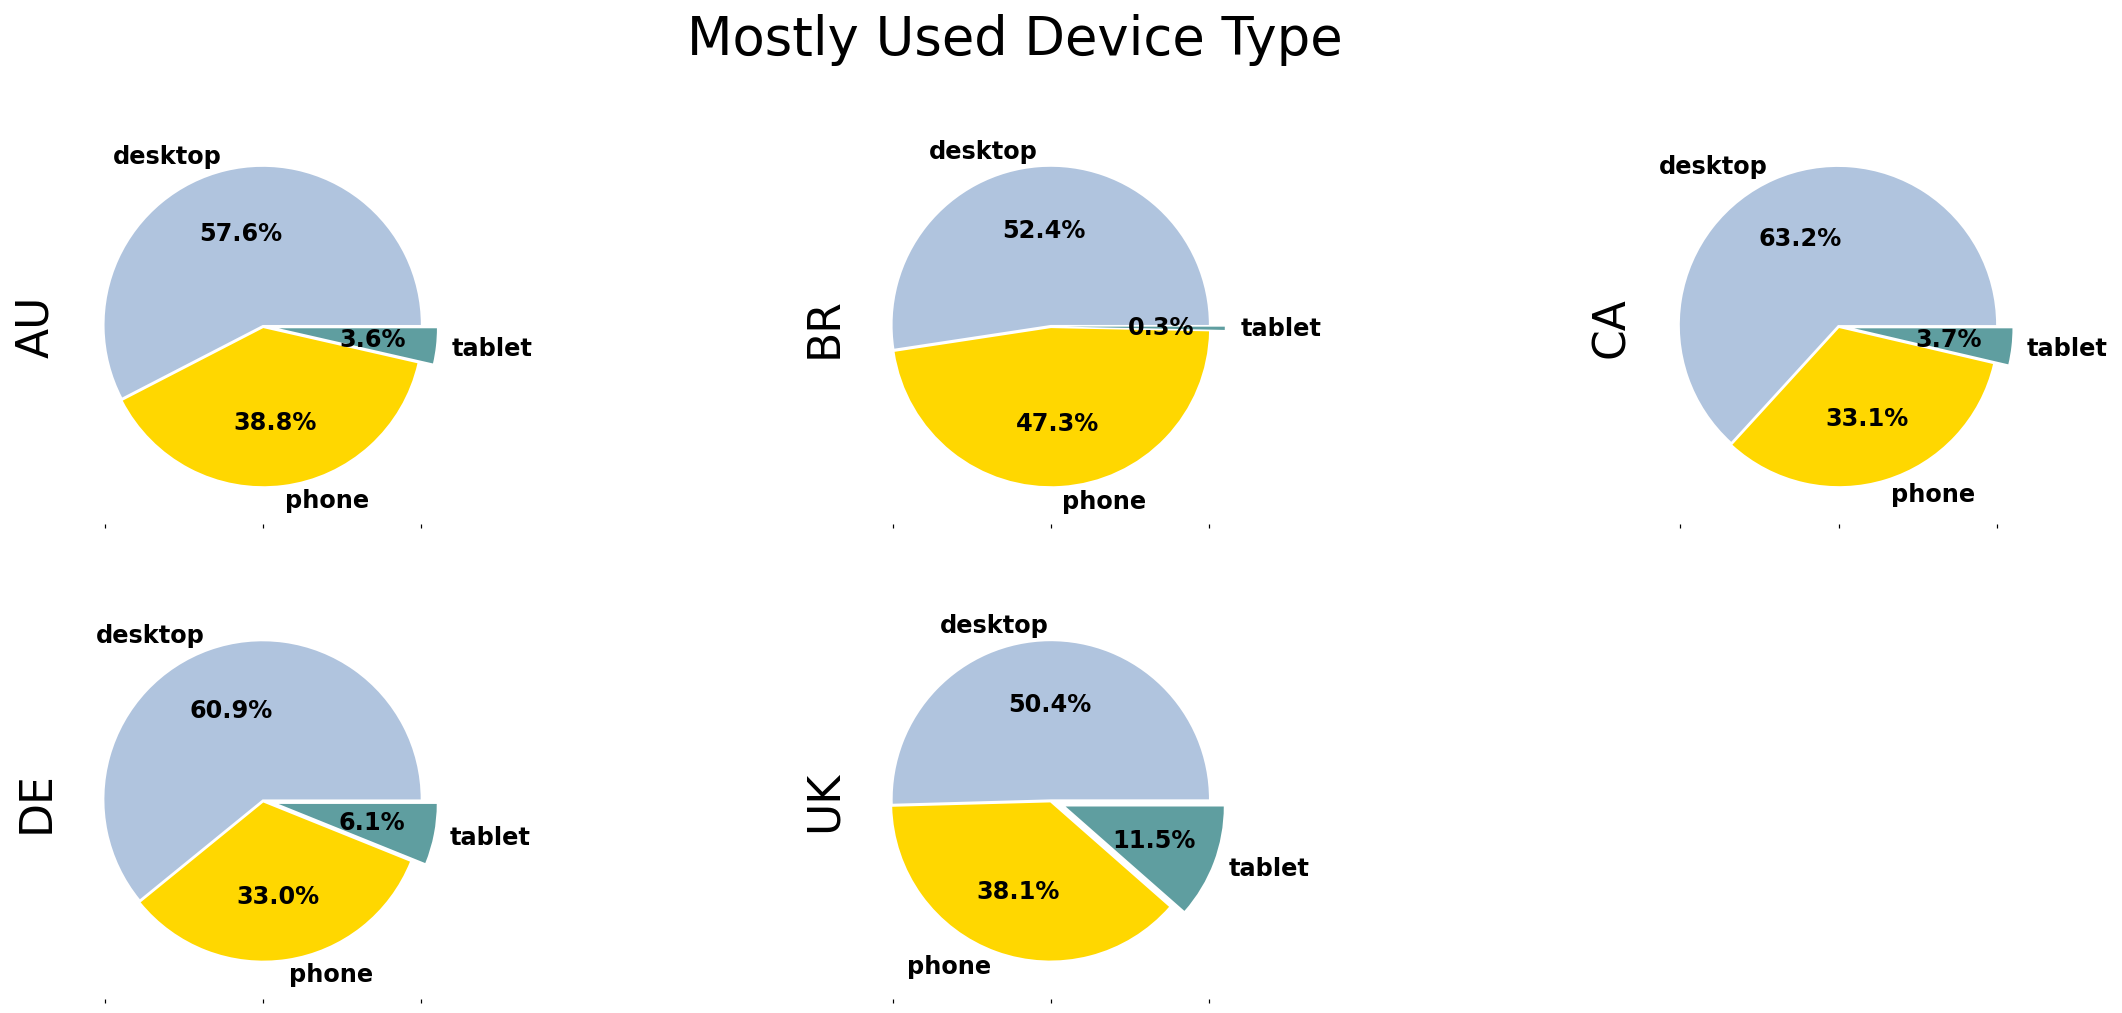

In [109]:
colors = random.choices(list(mcolors.CSS4_COLORS.values()),k = 3)
pie_chart = device_pivot.T.plot.pie(subplots=True, figsize=(20, 8), layout=(-1, 3), title="Mostly Used Device Type", rot=0,
                        autopct='%1.1f%%',legend=False, explode=[0.01, 0.01, 0.1], fontsize=12, colors=colors)
# plt.savefig("Mostly Used Device Type.png")

## How relevant the ads are?
The Click through rate is directly influences the ad relevance or ad quality. So let's see the ctr in each market. and overall globally.

In [113]:
market_wise_ctr_avg = df_use.groupby('market_code')['ctr_in_perc'].mean().to_frame().reset_index()
global_Avg = market_wise_ctr_avg.ctr_in_perc.mean()

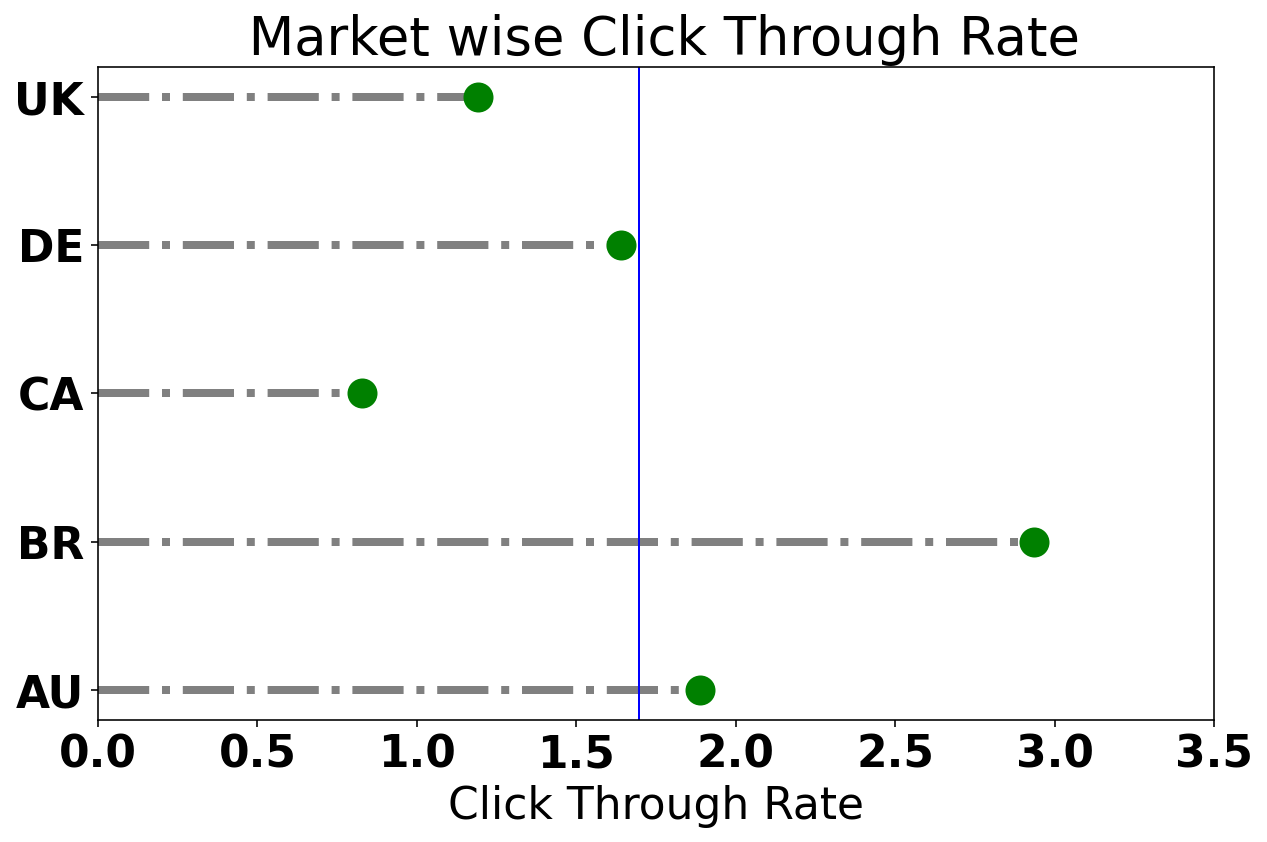

In [131]:
fig, ax = plt.subplots()
ax.hlines(market_wise_ctr_avg.market_code, xmin=0, xmax=market_wise_ctr_avg.ctr_in_perc, color='grey', linestyles='dashdot', linewidth=4)
ax.plot(market_wise_ctr_avg.ctr_in_perc, market_wise_ctr_avg.market_code, "o", color='green', markersize=14)
ax.set_xlim(0, 3.5)
plt.axvline(x=global_Avg,linewidth=1, color='blue', label="Global Avg")

ax.set_facecolor('xkcd:white')
ax.set_xlabel("Click Through Rate")
ax.set_title(" Market wise Click Through Rate")
plt.savefig("Market wise Click Through Rate.png")

## How is the market wise growth?
Conversion rate(CR) is the metrics to measure how growth is market wise. CR effectively implies how many bookings has been done.

In [133]:
market_wise_cr = df_use.groupby('market_code')['conversion_rate'].mean().to_frame().reset_index()
global_cr = market_wise_cr.conversion_rate.mean()

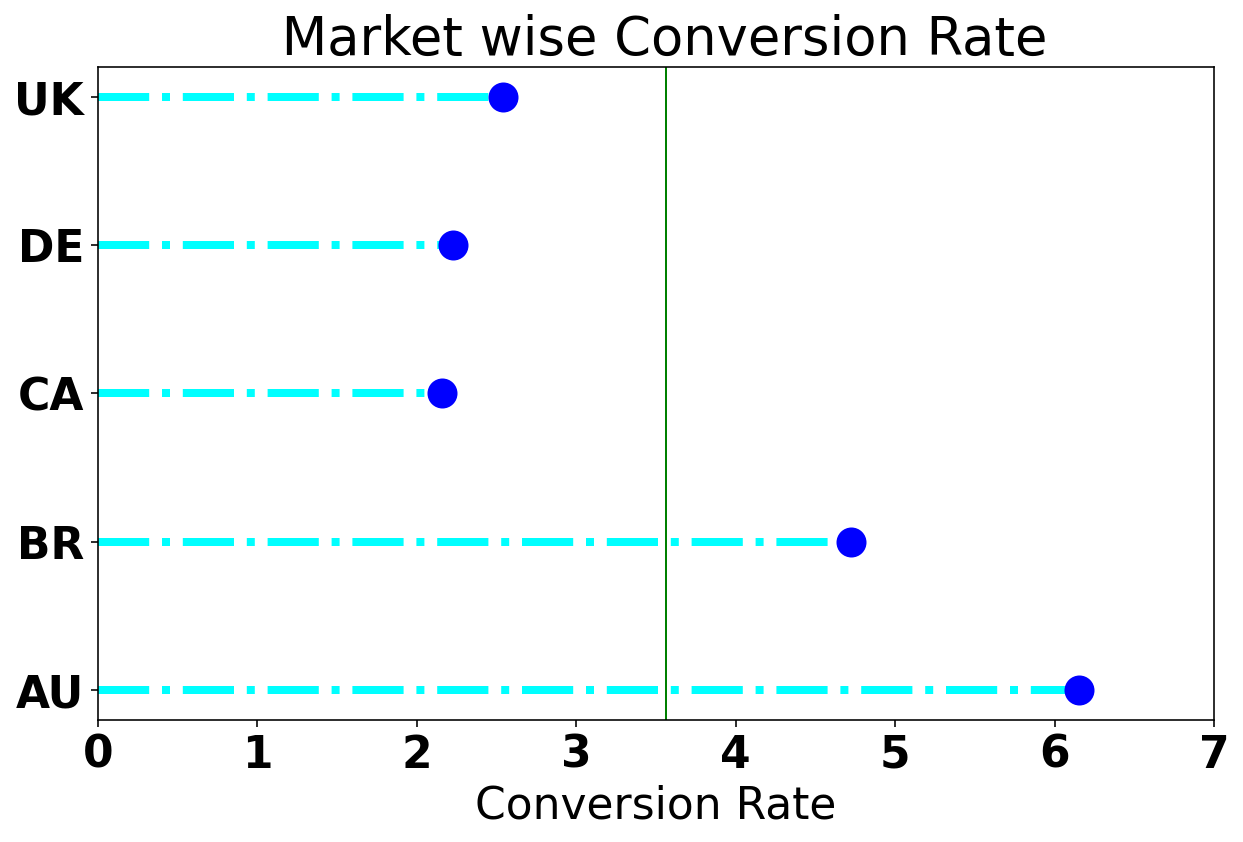

In [140]:
fig, ax = plt.subplots()
ax.hlines(market_wise_cr.market_code, xmin=0, xmax=market_wise_cr.conversion_rate, color='cyan', linestyles='dashdot', linewidth=4)
ax.plot(market_wise_cr.conversion_rate, market_wise_cr.market_code, "o", color='blue', markersize=14)
ax.set_xlim(0, 7.0)
plt.axvline(x=global_cr,linewidth=1, color='green', label="Global Avg")

ax.set_facecolor('xkcd:white')
ax.set_xlabel("Conversion Rate")
ax.set_title(" Market wise Conversion Rate")
plt.savefig("Market wise Conversion Rate.png")

## Which theme word is popular among users?

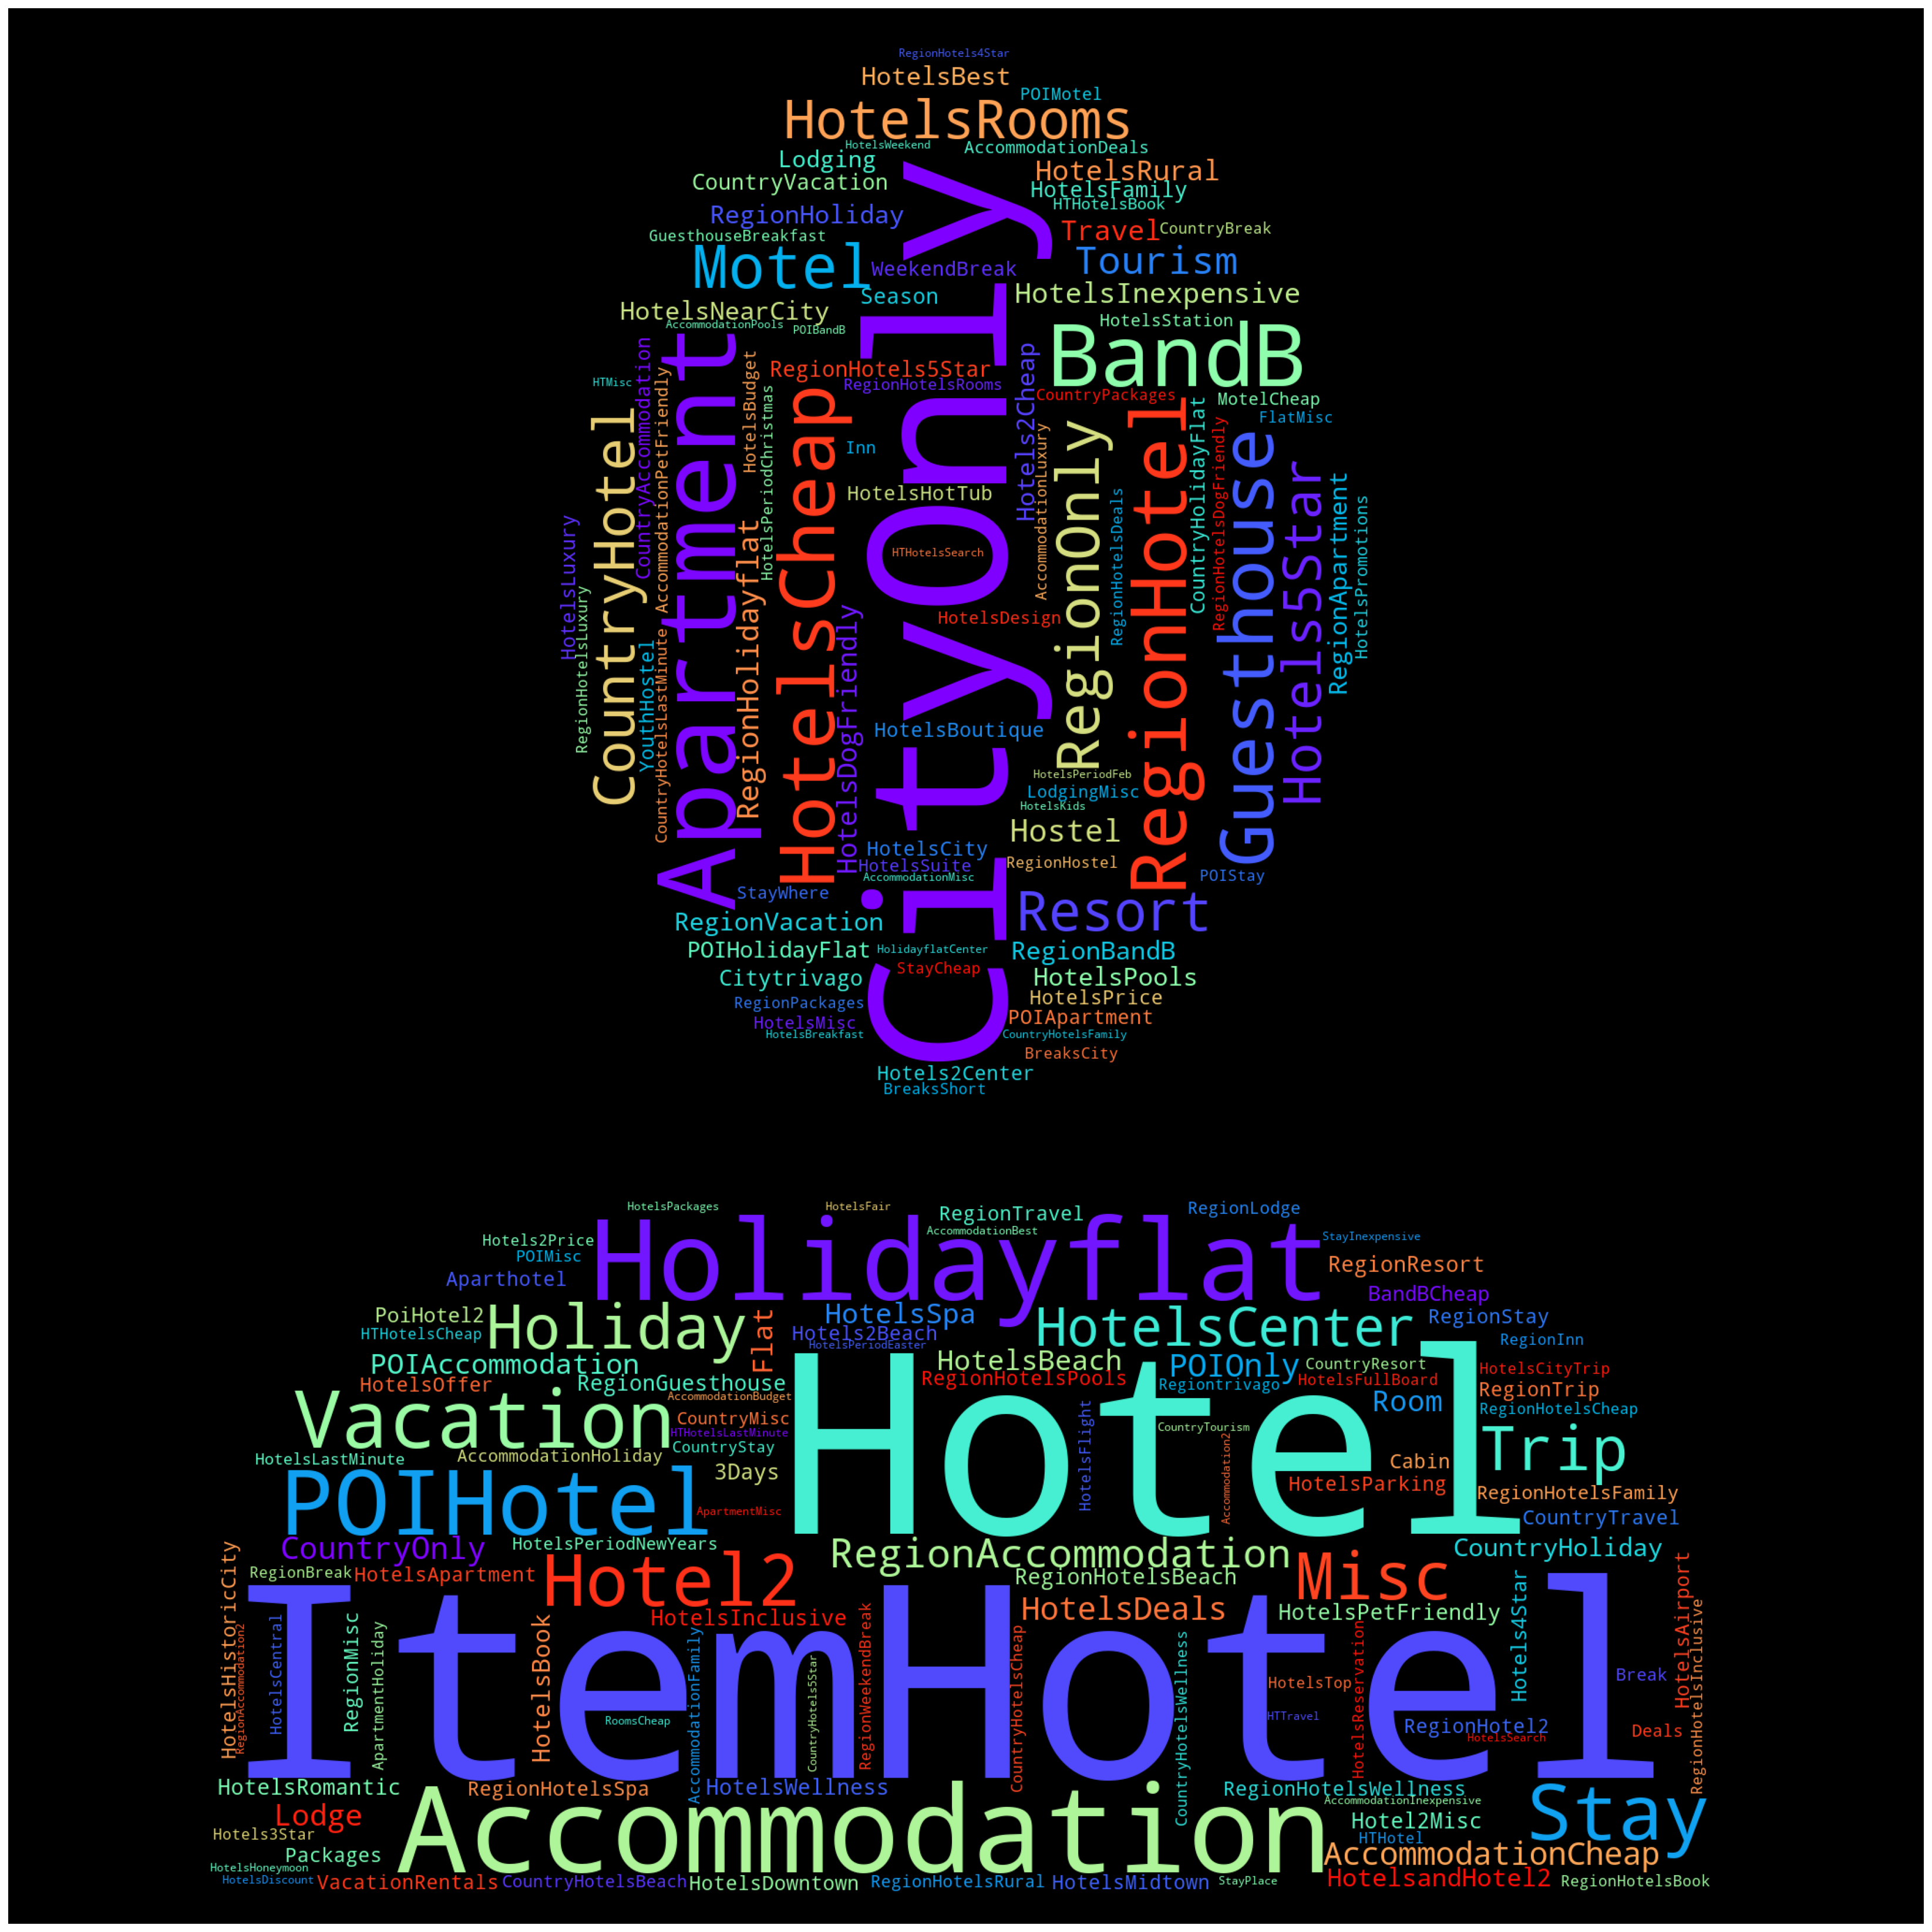

In [156]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")
    
text = ' '.join(df_use['theme_name_english'])
# Import image to np.array
mask = np.array(Image.open('user.png'))

# Generate wordcloud
wordcloud = WordCloud(width = 600, height = 400, random_state=1, background_color='black', 
                      colormap='rainbow', collocations=False, stopwords = STOPWORDS, mask=mask).generate(text)
plot_cloud(wordcloud)
# Save image
wordcloud.to_file("wordcloud.png")

## What is the best performing market?
>>The best performing market would be where the CTR is moderate along with highest Conversion rate. The reason why we need moderate CTR is that it might improve Trivago's website ranking in a organic search or users might land into Trivago's page but might not complete any actions or bookings, hence heighest CTR will lead to increase the cost per clicks. Therefore, the best market would be where CTR is also good (not best) along with heighest conversion rate. According to the data provided "AU" appeared to be the best market. This fact is again verified when we will see the avg revenue per clickin is highest in "AU".

## What are the global and Market average trivago revenue per clickin?
>>Revenue per clickins essentially measures how many users who landed on the trivago website actually made some bookings. For instance 1000 users are landing on trivago website daily but only 5 out if them are actually going through booking process to the end. In this scenario if we consider cost per click as our performance evaluation we will see good numbers and we can assume our website is popular enough but whereas the actual generated revenue is not equal to this measure. Hence, a website's performance evaluation should always include reveneu per clickin metric also.

In [ ]:
#rev per click in = rev value * Conversion rate(CR)
market_avg_rev_and_CR = df_use.groupby('market_code')[['clickout_rev', 'conversion_rate']].mean().reset_index()

In [23]:
market_avg_rev_and_CR['avg_rev_per_clickin'] = market_avg_rev_and_CR.clickout_rev * market_avg_rev_and_CR.conversion_rate

In [25]:
global_avg_rev_and_CR = market_avg_rev_and_CR['avg_rev_per_clickin'].mean()

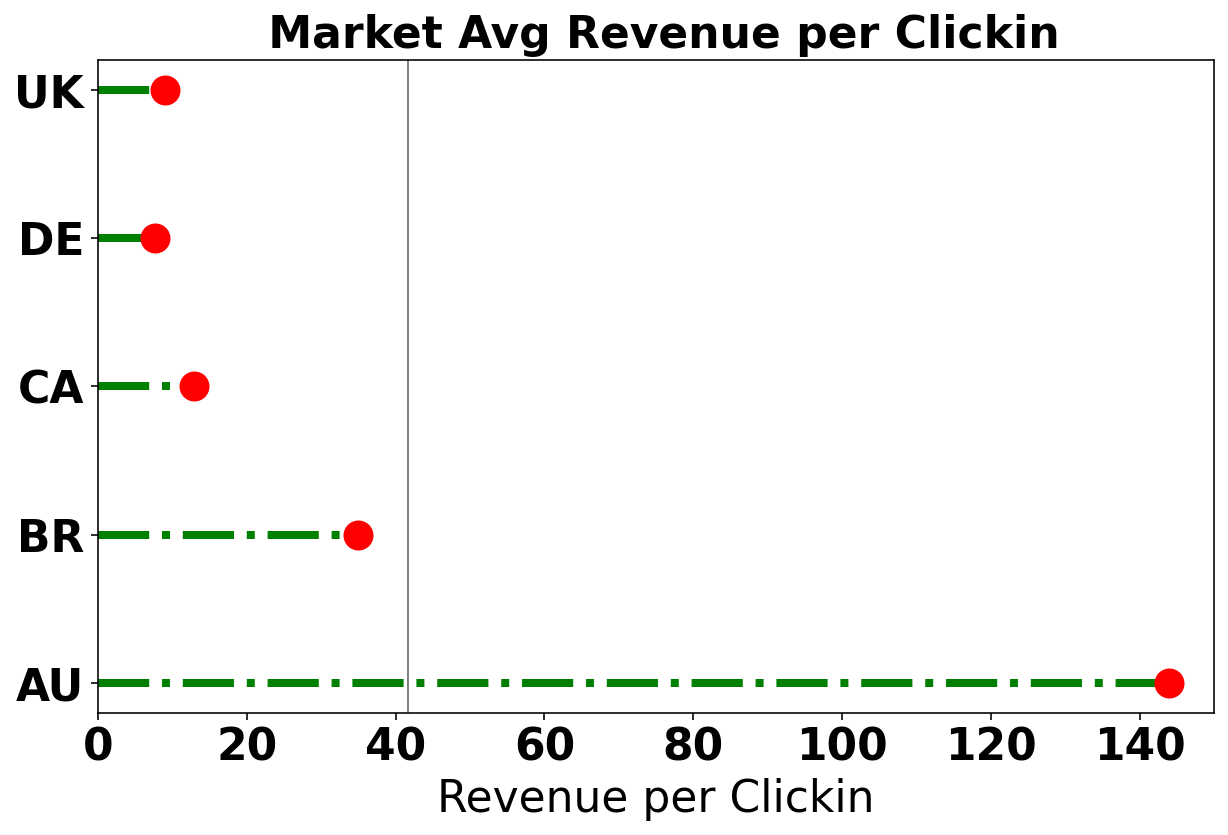

In [29]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)
fig, ax = plt.subplots()
ax.hlines(market_avg_rev_and_CR.market_code, xmin=0, xmax=market_avg_rev_and_CR.avg_rev_per_clickin, 
          color='green', linestyles='dashdot', linewidth=4)
ax.plot(market_avg_rev_and_CR.avg_rev_per_clickin, market_avg_rev_and_CR.market_code, "o", color='red', markersize=14)
ax.set_xlim(0, 150)
plt.axvline(x=global_avg_rev_and_CR,linewidth=1, color='grey', label="Global Avg")

ax.set_facecolor('xkcd:white')
ax.set_xlabel("Revenue per Clickin")
ax.set_title(" Market Avg Revenue per Clickin", font='bold')
plt.savefig("Market Avg Revenue per Clickin.png")

## Other valuable KPIs to be considered:
 New Visitors vs. Returning Visitors: 
>>This will help to understand how much influential the content of the website, as well as it will help to monitor new users vs returning visitors. The rate of returning visitors will help to evaluate the effectiveness of the content. 

Bounce rate: 
>>This metric focuses on how many users left the website instantly. Again this will help to improve the website content, website loading time etc.

## What should be the average price to pay for conversion (clickout) if we want to
## achieve 125% ROAS globally; per market?

In [62]:
# Calculating metrics
# roas per market(country) = rev generated by ad spend / total ad spend
roas_per_market = (df_use.groupby('market_code')['clickout_rev'].sum() / df_use.groupby('market_code')['cost'].sum())

# calculating Cost-Per-Conversion = Total cost for clicks / Number of conversions  as cpc
cpc_per_market = df_use.groupby('market_code')['cost'].sum() / df_use.groupby('market_code')['clickout'].sum()
# market wise total revenue
total_rev = df_use.groupby('market_code')['clickout_rev'].sum()
# market wise clickouts
market_clickouts = df_use.groupby('market_code')['clickout'].sum()
roas_df = pd.concat([roas_per_market, cpc_per_market, total_rev, market_clickouts], axis=1).reset_index()

In [63]:
roas_df.columns = ['market','roas', 'cpc_current', 'total_rev', 'clickouts']

In [69]:
roas_df

,market,roas,cpc_current,total_rev,clickouts,roas_125,cpc_new
0,AU,0.860612,89.046675,2759995,36015,1.936376,39.576300
1,BR,0.664148,25.351077,1942437,115368,1.494334,11.267145
2,CA,1.339477,43.573045,453847,7776,3.013824,19.365798
3,DE,0.546976,133.833473,1830019,24999,1.230696,59.481544
4,UK,0.644034,90.939635,999350,17063,1.449077,40.417616


In [68]:
# increasing roas by 125%
roas_df['roas_125'] = (roas_df.roas * 1.25) + roas_df.roas
# calculating new cpc using increased roas value, cpc= total rev / (roas_new * clickout)
roas_df['cpc_new'] = roas_df.total_rev / (roas_df.roas_125 * roas_df.clickouts)
avg_cpc = roas_df.cpc_new.mean()
avg_cpc

34.02168050013636

    The average price for conversion would be [avg_cpc] i.e. 34.02168050013636 if you increase ROAS by 125%.
    To implement this the share of clicks coming from different market has to be increased by the same %.